In [12]:
%matplotlib inline
import matplotlib
import pandas as pd
import networkx as nx
from pprint import pprint
from collections import OrderedDict
import matplotlib.pyplot as plt
import os
from pprint import pprint



In [10]:
# set up the  hscode nodes

def get_hsc_df():
    file = './../../Data_1/HS_code_descriptions/hs_codes_file_4.csv'
    df = pd.read_csv(file, index_col=0)
    return df



In [14]:
#Node type 1 
class node:
    def __init__(self, id = None):
        self.id = id
        self.is_root = False
        self.is_leaf = False
        self.is_tropical = None
        self.is_coniferous = None
        self.label = 0
    
    def set_label(self,label):
        self.label = label
        

def draw_graph(G):
    nx.drawing.nx_pylab.draw_spring(G,node_size=25)
    plt.show()

def draw_graph_colored(G):

#     pos = nx.fruchterman_reingold_layout(G)
    pos = nx.spring_layout(G)
#     pos= graphviz_layout(G, prog='dot')
    all_nodes = G.nodes()
    node_id = {}
    
    for n in all_nodes:
        node_id[n] = n.id

    #color by type
    type1 = []
    type2 = []

    for n in all_nodes:
        if n.label == 1 :
            type1.append(n)
        else :
            type2.append(n)

    plt.figure(figsize=[40,20])
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=type1,
        node_color='r',
        node_size=300,
        alpha=0.8
    )
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=type2,
        node_color='b',
        node_size=250,
        alpha=0.25
    )
    nx.draw_networkx_edges(G, pos, width=0.75, alpha = 0.5)
    nx.draw_networkx_labels(G, pos, node_id, font_size = 16)
    plt.show()

In [55]:
import re
def remove_trail_zeros(hsc):
    pattern = '(\.00)*$'
    return re.sub(pattern,'',hsc)

In [57]:
# Set labels for hs code nodes - with lacey act codes we have
l_act = []
with open('./../preprocess_3/LaceyAct_HS_Codes.txt','r') as f:
    res = f.read()
    res = res.split('\n')
    for t in res :
        if t != '' : 
            l_act.append(remove_trail_zeros(t))
#             print(t)
l_act = list(sorted(l_act))
pprint (l_act)

['4401.10',
 '4401.21',
 '4401.22',
 '4401.31',
 '4401.39.20',
 '4401.39.40.10',
 '4401.39.40.20',
 '4401.39.40.90',
 '4402.10',
 '4402.90',
 '4403.10.00.20',
 '4403.10.00.40',
 '4403.10.00.50',
 '4403.10.00.60',
 '4403.20.00.04',
 '4403.20.00.12',
 '4403.20.00.15',
 '4403.20.00.16',
 '4403.20.00.20',
 '4403.20.00.30',
 '4403.20.00.35',
 '4403.20.00.40',
 '4403.20.00.42',
 '4403.20.00.45',
 '4403.20.00.50',
 '4403.20.00.52',
 '4403.20.00.55',
 '4403.20.00.57',
 '4403.20.00.63',
 '4403.20.00.65',
 '4403.49',
 '4403.91.00.20',
 '4403.91.00.40',
 '4403.92',
 '4403.99.00.22',
 '4403.99.00.24',
 '4403.99.00.26',
 '4403.99.00.27',
 '4403.99.00.29',
 '4403.99.00.30',
 '4403.99.00.40',
 '4403.99.00.50',
 '4403.99.00.55',
 '4403.99.00.60',
 '4403.99.00.67',
 '4403.99.00.70',
 '4403.99.00.75',
 '4403.99.00.91',
 '4404.10.00.40',
 '4404.10.00.80',
 '4404.10.00.90',
 '4404.20.00.40',
 '4404.20.00.80',
 '4404.20.00.90',
 '4405',
 '4406.10',
 '4406.90',
 '4407.10.01.01',
 '4407.10.01.02',
 '4407.10.

In [59]:
def find_hsc_ancestor(graph_obj, root, idx, df):
    # --------------------- #
    def hsc_is_child(candidite_hsc, hs_code):
        result = False
        if len(hs_code) > len(candidite_hsc):
            prefix = hs_code[0:len(candidite_hsc)]
            if prefix == candidite_hsc:
                return True
        return result

    # --------------------- #
    cur_row = df.loc[idx]
    cur_indent = cur_row['Indent']
    hs_code = cur_row['hs_code']
    res = root
    if cur_indent == 0:
        return root

    # find the hs code with indent = cur_indent-1
    for i in range(idx, -1, -1):
        _indent = df.loc[i, 'Indent']
        candidite_hsc = df.loc[i, 'hs_code']

        if type(candidite_hsc) != str:
            continue

        if _indent < cur_indent and hsc_is_child(candidite_hsc, hs_code):
            all_nodes = graph_obj.nodes()
            for n in all_nodes:
                if n.id == candidite_hsc:
                    res = n
                    return res
    return res


# --------------------- #

    
def create_hsc_subgraph(G):
    df = get_hsc_df()
    root_node = node('0')
    root_node.is_root = True
    G.add_nodes_from([root_node])
    count = 0
    
    for idx, row in df.iterrows():
        hs_code = row['hs_code']

        if type(hs_code) != str:
            continue
            
#         print(hs_code,remove_trail_zeros(hs_code))
        hs_code = remove_trail_zeros(hs_code)
        # create_node
        node_obj = node(hs_code)
        node_obj.is_leaf = True
    
        G.add_nodes_from([node_obj])
        anc = find_hsc_ancestor(G, root_node, idx, df)
        
        if hs_code in l_act :
            node_obj.set_label(1)
        else :
            node_obj.set_label(-1)
        G.add_edge(anc ,node_obj,  weight = 1.0)
        anc.is_leaf = False
    return G

G = nx.DiGraph()
G = create_hsc_subgraph(G)

# print(all_node_ids)

In [60]:

all_node_ids = sorted([n.id for n in G.nodes()])
for i in l_act :
    if i not in all_node_ids :
        print(i)

4403.20.00.45
4403.20.00.63
4403.49
4403.99.00.24
4403.99.00.29
4403.99.00.91
4407.29.01.80
4407.99.01.85
4407.99.01.93
4408.39.01.10
4408.39.01.90
4408.90.01.95
4409.29.05.15
4409.29.05.25
4409.29.05.35
4409.29.05.45
4409.29.05.55
4409.29.05.65
4409.29.10
4409.29.25.30
4409.29.25.50
4409.29.25.60
4409.29.40
4409.29.50
4409.29.60
4409.29.65
4409.29.90
4412.31.05.20
4412.31.05.40
4412.31.05.60
4412.31.25.10
4412.31.25.20
4412.31.40.40
4412.31.40.50
4412.31.40.60
4412.31.40.75
4412.31.40.80
4412.31.51.25
4412.31.51.65
4412.31.51.75
4412.31.60
4412.31.91
4412.32.05.20
4412.32.05.40
4412.32.05.65
4412.32.05.70
4412.32.25.10
4412.32.25.25
4412.32.25.30
4412.32.31.25
4412.32.31.35
4412.32.31.55
4412.32.31.65
4412.32.31.75
4412.32.31.85
4412.32.56
4412.94.31.60
4412.94.31.71
4418.71.10
4418.71.20
4418.71.90
4418.72.20
4418.72.91
4418.72.95
4418.79
4418.90.25
4418.90.46.05
4418.90.46.10
4418.90.46.20
4418.90.46.40
4418.90.46.50
4418.90.46.95
4419.00.40
4419.00.80
4421.90.10
4421.90.15
4421.90.

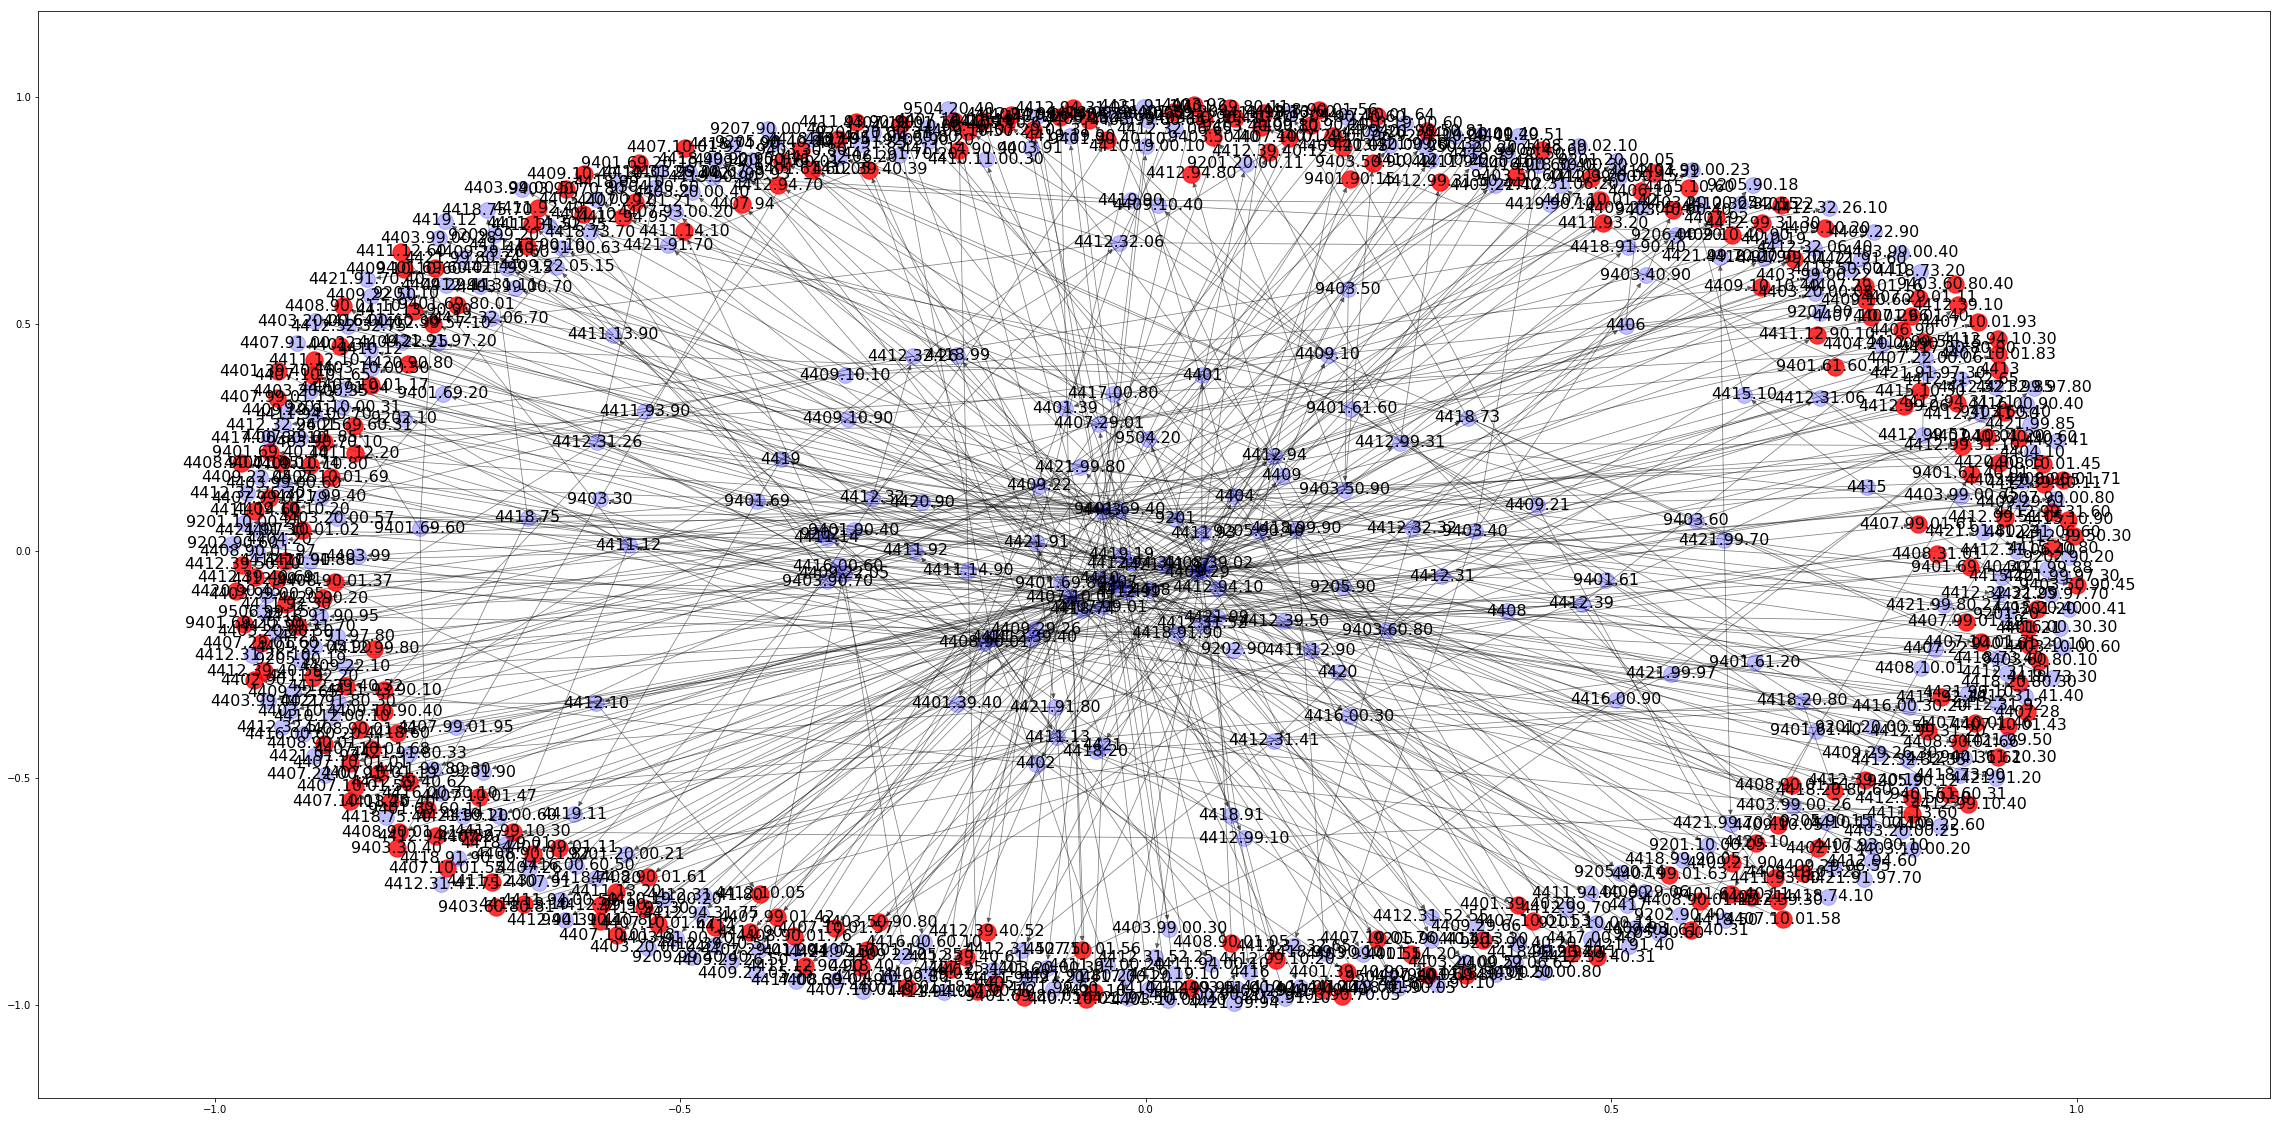

In [45]:
draw_graph_colored(G)

In [18]:


# p=nx.drawing.nx_pydot.to_pydot(G)
# p.write_png('example.png')


ImportError: No module named 'plotly'

In [46]:
print ('hscode| ', 'label') 
for n in G.nodes():
    if n.is_root == False and len(n.id) == 4 :
        print (n.id, ' | ', n.label) 

hscode|  label
4408  |  -1
4413  |  1
4416  |  -1
4409  |  -1
9202  |  -1
9201  |  -1
4412  |  -1
4420  |  -1
4417  |  -1
4404  |  -1
4414  |  1
4419  |  -1
4418  |  -1
4415  |  -1
4402  |  -1
4410  |  -1
4421  |  -1
4411  |  -1
4401  |  -1
4405  |  1
4406  |  -1
4403  |  -1
4407  |  -1


In [47]:
for n in G.nodes():
    if n.is_root == False and len(n.id) == 7 :
        print (n.id, ' | ', n.label)  

9401.69  |  -1
9205.90  |  -1
4418.73  |  -1
9403.40  |  -1
4418.20  |  -1
4402.10  |  1
9504.20  |  -1
4415.20  |  -1
9201.90  |  -1
4404.20  |  -1
4409.10  |  -1
9201.10  |  -1
4418.10  |  1
4418.40  |  1
4409.21  |  -1
4407.22  |  -1
4409.22  |  -1
4407.21  |  1
4418.74  |  -1
4411.93  |  -1
4411.94  |  -1
4407.93  |  -1
4420.10  |  1
4407.25  |  1
4412.10  |  -1
4412.31  |  -1
4411.12  |  -1
4407.27  |  1
4421.91  |  -1
4418.91  |  -1
4407.28  |  1
4412.32  |  -1
9207.90  |  -1
4407.92  |  1
4407.94  |  1
4411.13  |  -1
4412.39  |  -1
4401.31  |  1
4407.26  |  -1
4402.90  |  1
4419.12  |  -1
4419.11  |  -1
4419.19  |  -1
4401.39  |  -1
4419.90  |  -1
9202.90  |  -1
4420.90  |  -1
9403.30  |  -1
4421.10  |  1
4418.75  |  -1
4403.20  |  -1
4407.91  |  -1
4421.99  |  -1
4412.99  |  -1
9202.10  |  -1
4409.29  |  -1
4412.94  |  -1
9403.60  |  -1
4403.41  |  -1
9401.61  |  -1
4418.50  |  -1
4410.11  |  -1
4403.10  |  -1
4403.92  |  1
4403.99  |  -1
4410.12  |  -1
9403.50  |  -1
4410.19  

In [48]:
for n in G.nodes():
    if n.is_root == False and len(n.id) == 10 :
        print (n.id, ' | ', n.label) 

4412.99.95  |  1
9401.90.15  |  1
4412.94.70  |  1
9504.20.40  |  -1
9205.90.14  |  -1
4415.10.60  |  1
9403.50.40  |  1
4408.10.01  |  -1
4416.00.90  |  -1
4412.99.31  |  -1
4418.73.10  |  -1
4408.39.02  |  -1
4408.31.01  |  1
9403.50.60  |  1
4408.90.01  |  -1
4412.99.51  |  -1
4418.73.70  |  -1
4418.99.90  |  -1
4421.99.85  |  -1
9206.00.20  |  -1
4418.20.80  |  -1
4412.94.60  |  -1
4407.99.01  |  -1
4418.73.60  |  -1
4409.10.05  |  1
9504.20.80  |  -1
4409.10.10  |  -1
9401.69.80  |  -1
4418.73.90  |  -1
4409.10.20  |  1
9403.40.90  |  -1
4409.10.40  |  -1
4409.10.45  |  1
4409.10.50  |  1
4409.10.65  |  1
4409.10.60  |  1
4409.10.90  |  -1
4412.99.70  |  -1
4409.21.05  |  1
4418.74.10  |  -1
4421.99.50  |  -1
4409.21.90  |  1
4418.74.20  |  -1
4409.22.05  |  -1
4412.94.80  |  1
9205.90.12  |  -1
4418.74.90  |  -1
9403.40.60  |  1
9202.90.40  |  -1
4409.22.25  |  -1
4409.22.10  |  -1
9205.90.60  |  -1
4409.22.50  |  -1
9401.61.40  |  -1
4416.00.60  |  -1
9401.69.20  |  -1
4411.93.3

In [49]:
for n in G.nodes():
    if n.is_root == False and len(n.id) == 13 :
        print (n.id, ' | ', n.label) 

9403.90.70.05  |  1
4407.99.01.13  |  1
4407.99.01.11  |  1
4407.99.01.19  |  1
4407.99.01.42  |  1
9403.50.90.41  |  1
4410.11.00.20  |  -1
4407.99.01.61  |  1
9401.61.60.11  |  1
4407.99.01.63  |  1
4407.10.01.82  |  -1
4407.99.01.72  |  1
4407.99.01.79  |  1
4407.99.01.95  |  -1
4412.99.10.40  |  1
4410.11.00.30  |  -1
4408.10.01.25  |  1
4408.10.01.45  |  1
9401.61.60.05  |  1
4401.39.40.20  |  1
4410.11.00.60  |  -1
4408.39.02.10  |  -1
4403.99.00.40  |  -1
4408.39.02.90  |  -1
4408.90.01.10  |  1
4418.99.90.05  |  -1
4408.90.01.05  |  1
4412.39.40.69  |  1
9401.69.80.31  |  1
4408.90.01.15  |  1
9201.20.00.05  |  -1
4408.90.01.21  |  1
4412.31.06.20  |  -1
4408.90.01.37  |  1
4408.90.01.31  |  1
4407.10.01.53  |  1
4408.90.01.45  |  1
4408.90.01.51  |  1
9201.20.00.11  |  -1
4408.90.01.61  |  1
9401.69.60.01  |  1
4410.12.00.10  |  -1
4408.90.01.56  |  1
4416.00.30.10  |  -1
4408.90.01.66  |  1
4408.90.01.71  |  1
4408.90.01.81  |  1
4408.90.01.76  |  1
4408.90.01.87  |  1
4408.9